# Exercício Caps. 10 e 11 - transmitância de gases na atmosfera e da água pura - Absorção e Espalhamento.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pfser_atividades import sum_radiation, atmospheric_state_variables, transmitance, plots

In [2]:
# Graph style

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

## Sum radiance

In [3]:
# Parameters

latitude = -22.60877
date = '2022-01-17'
time = '14:10'

sum_constant_wavelength = {
    '460nm': 2099.99,
    '540nm': 1857.50,
    '650nm': 1597.50,
    '760nm': 1222.50,
    '800nm': 1144.70,
}

In [4]:
julian_day = sum_radiation.get_julian_day(date)
day_angle = sum_radiation.compute_day_angle(date)
sum_hour = sum_radiation.compute_sum_hour(time)
sum_declination = sum_radiation.compute_sum_declination(day_angle)
corr_factor = sum_radiation.compute_excentric_corr_factor(day_angle)
zenith_angle, cos_zenith_angle = sum_radiation.compute_zenith_angle(sum_declination, sum_hour, latitude)

In [5]:
# Computing irradiance and radiance for each wavelengh

irradiance_parameters = {
    'correction_factor': corr_factor,
    'sum_declination': sum_declination,
    'sum_hour': sum_hour, 
    'latitude': latitude,
}

irradiance = {wavelength: sum_radiation.compute_irradiance(sum_constant=sum_constant, **irradiance_parameters) 
              for wavelength, sum_constant in sum_constant_wavelength.items()}
radiance = {wavelength: sum_radiation.compute_radiance(irradiance_) for wavelength, irradiance_ in irradiance.items()}

#### Optical paths

In [6]:
max_altitude = 3000000 # altitude in cm (since our coefficients are in this scale)
max_depth = 200 # depth in meters

In [7]:
altitude = np.linspace(0, max_altitude, num=100)
depth = np.linspace(0, max_depth, num=100)

In [8]:
optical_path_atmosphere = transmitance.optical_path(altitude, cos_zenith_angle)
optical_path_water = transmitance.optical_path(depth, cos_zenith_angle)

## Computing exticntion coefficients

### Atmosphere

#### Computing gas molecule density

In [9]:
gases_density = atmospheric_state_variables.compute_gases_density()

#### Gases cross-sections

##### Absorption

In [10]:
# Obs: cross_sections (cm²/molecule)

absorption_cross_sections_oxigen = {
    '460nm': 8.37e-27,
    '540nm': 4.27e-27,
    '650nm': 2.17e-27,
    '760nm': 2.79e-24, # https://uvvis.mpch-mainz.gwdg.de/uvvis/cross_sections/Oxygen/O2_Bogumil(2003)_293K_650-799.6nm.txt
    '800nm': 1.55e-27, # https://uvvis.mpch-mainz.gwdg.de/uvvis/cross_sections/Oxygen/O2_Bogumil(2003)_293K_650-799.6nm.txt
}

absorption_cross_sections_methane = {
    '460nm': 1.60e-27,
    '540nm': 2.67e-26,
    '650nm': 1.41e-26,
    '760nm': 1.89e-26, # https://uvvis.mpch-mainz.gwdg.de/uvvis_data/cross_sections/Alkanes+alkyl%20radicals/Alkanes/CH4_Giver(1978)_293K_694.5-860.5nm.txt
    '800nm': 3.35e-25,
}

In [11]:
absorption_coefficient_oxigen = transmitance.compute_coefficients(absorption_cross_sections_oxigen, gases_density['oxigen'])
absorption_coefficient_methane = transmitance.compute_coefficients(absorption_cross_sections_methane, gases_density['methane'])

absorption_coefficient_air = transmitance.aggregate_coefficients(
    [absorption_coefficient_oxigen, absorption_coefficient_methane]
)

##### Scattering

In [12]:
def refraction_index_carbon_dioxide(wavenumber):
    const = 1.1427 * 10 ** 11
    frac_1 = 5799.25 / (128908.9 ** 2 - wavenumber ** 2)
    frac_2 = 120.05 / (89223.8 ** 2 - wavenumber ** 2)
    frac_3 = 5.3334 / (75037.5 ** 2 - wavenumber ** 2)
    frac_4 = 4.3244 / (67837.7 ** 2 - wavenumber ** 2)
    frac_5 = 1.218145 * 10 ** -5 / (2418.136 **2 - wavenumber ** 2)

    return const * (frac_1 + frac_2 + frac_3 + frac_4 + frac_5)


def king_correction_factor_carbon_dioxide(wavenumber):

    return 1.1364 + 2.53 * (10 ** -11) * (wavenumber ** 2)


scattering_cross_sections_carbon_dioxide = transmitance.compute_rayleigh_cross_section(
    refraction_index_function=refraction_index_carbon_dioxide,
    king_correction_factor_function=king_correction_factor_carbon_dioxide,
    wavelengths=sum_constant_wavelength.keys(),
)

In [13]:
def refraction_index_oxigen(wavenumber):

    return 20564.8 + ((2.480899 * 10 ** 13) / (4.09 * 10 ** 9 - wavenumber ** 2))

def king_correction_factor_oxigen(wavenumber):
    
    return 1.09 + 1.385 * 10 ** -11 * wavenumber ** 2 + 1.448 * 10 ** -20 * wavenumber ** 4

scattering_cross_sections_oxigen = transmitance.compute_rayleigh_cross_section(
    refraction_index_function=refraction_index_oxigen,
    king_correction_factor_function=king_correction_factor_oxigen,
    wavelengths=sum_constant_wavelength.keys(),
)

In [14]:
def refraction_index_nitrogen(wavenumber):

    return 5677.465 + (318.81874 * 10 ** 12) / (1.44 * 10 ** 10 - wavenumber ** 2)

def king_correction_factor_nitrogen(wavenumber):
    
    return 1.034 + 3.17 * 10 ** -12 * wavenumber ** 2

scattering_cross_sections_nitrogen = transmitance.compute_rayleigh_cross_section(
    refraction_index_function=refraction_index_nitrogen,
    king_correction_factor_function=king_correction_factor_nitrogen,
    wavelengths=sum_constant_wavelength.keys(),
)

In [15]:
def refraction_index_methane(wavenumber):
    return 4869.8 + (4.1023 * 10 ** 14) / (1.133 * 10 ** 10 - wavenumber ** 2)

def king_correction_factor_methane(wavenumber):
    return 1

scattering_cross_sections_methane = transmitance.compute_rayleigh_cross_section(
    refraction_index_function=refraction_index_methane,
    king_correction_factor_function=king_correction_factor_methane,
    wavelengths=sum_constant_wavelength.keys(),
)

In [16]:
# absorption_coefficient_nitrogen_dioxide = transmitance.compute_coefficients(cross_sections_nitrogen_dioxide, gases_density['nitrogen_dioxide'])
scattering_coefficient_carbon_dioxide = transmitance.compute_coefficients(scattering_cross_sections_carbon_dioxide, gases_density['carbon_dioxide'])
scattering_coefficient_oxigen = transmitance.compute_coefficients(scattering_cross_sections_oxigen, gases_density['oxigen'])
scattering_coefficient_nitrogen = transmitance.compute_coefficients(scattering_cross_sections_nitrogen, gases_density['nitrogen'])
scattering_coefficient_methane = transmitance.compute_coefficients(scattering_cross_sections_methane, gases_density['methane'])

scattering_coefficient_air = transmitance.aggregate_coefficients(
    [scattering_coefficient_carbon_dioxide,
    #  scattering_coefficient_nitrogen_dioxide,
     scattering_coefficient_oxigen,
     scattering_coefficient_nitrogen,
     scattering_coefficient_methane]
)

##### Extinction coefficient

In [17]:
extinction_coefficient_air = transmitance.aggregate_coefficients(
    [absorption_coefficient_air, scattering_coefficient_air]
)

#### Transmitance

In [18]:
transmitance_air = transmitance.compute_transmitance(optical_path_atmosphere, extinction_coefficient_air)

#### Attenuation

In [19]:
attenuation_air = transmitance.compute_attenuation(irradiance, transmitance_air)

#### Plots

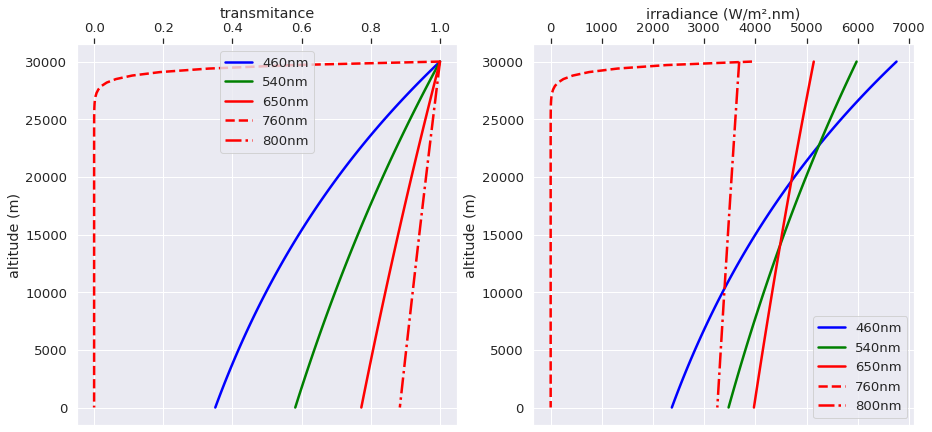

In [20]:
plots.plot_transmitance(transmitance=transmitance_air,
                        attenuation=attenuation_air,
                        altitude=altitude,);

### Water

In [21]:
# Updated irradiance_values

updated_irradiance = {key:value[-1] for key, value in attenuation_air.items()}

In [22]:
absorption_coefficient_water= {
    '460nm': 0.00979, # Pope e Fry (1997)
    '540nm': 0.0474, # Pope e Fry (1997)
    '650nm': 0.340, # Pope e Fry (1997)
    '760nm': 2.55, # Smith e Baker(1981
    '800nm': 2.07, # Smith e Baker(1981
}

In [23]:
scattering_coefficient_water= {
    '460nm': 0.003, # Buiteveld, Hakvoort & Donze, M. (1994)
    '540nm': 0.0015, # Buiteveld, Hakvoort & Donze, M. (1994)
    '650nm': 0.0007, # Buiteveld, Hakvoort & Donze, M. (1994)   
    '760nm': 0.0004, # Buiteveld, Hakvoort & Donze, M. (1994) 
    '800nm': 0.0003, # Buiteveld, Hakvoort & Donze, M. (1994)
}

In [24]:
extinction_coefficient_water = transmitance.aggregate_coefficients(
    [absorption_coefficient_water, scattering_coefficient_water]
)

#### Transmitance

In [25]:
transmitance_water = transmitance.compute_transmitance(optical_path_water, extinction_coefficient_water)

#### Attenuation

In [26]:
attenuation_water = transmitance.compute_attenuation(updated_irradiance, transmitance_water)

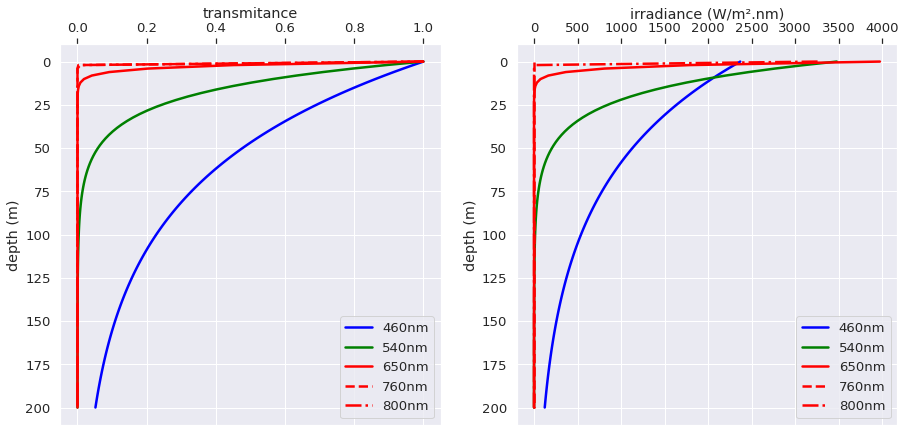

In [27]:
plots.plot_transmitance(transmitance=transmitance_water,
                        attenuation=attenuation_water,
                        altitude=depth,
                        water=True);